# Review Image Features

Use different pretrained or finetunes CNN models to extrace image features and represent them in reduced version with UMAP

Objective is to visualize whether the images in each datasets are from compatible distributions.

## Imports and Setup

In [72]:
from eccore.ipython import nb_setup
nb_setup()

import matplotlib.pyplot as plt
import re
import torch
import umap

from pprint import pprint
from uuid import uuid4
from IPython.display import Markdown, display


from fastai import __version__ as fastai_version
from fastai.vision.all import *
from fastai.callback.all import ShowGraphCallback
from pathlib import Path
from utils import run_experiment, create_image_features, plot_features, parse_saved_fnames, ROOT, DATASETS
from utils import validate_models, plot_training_and_validation_metrics, model_weight_files

print(f"Using fastai version {fastai_version}")
saved = ROOT / "saved"
data = ROOT / "data"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# styles = plt.style.available
plt.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set autoreload mode
Using fastai version 2.8.3
Using device: cuda


## Using resnet18 models fine-tuned with `msld-v1`

In [114]:
selected_arch = resnet18
dataset = 'msld-v1'

saved_model_files = model_weight_files(arch=selected_arch, dataset=dataset)
saved_model_files

[Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_32_1.0e-03_msld-v1_weights_c229fec0-b6c1-4056-a779-90d602af250b.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_16_1.0e-03_msld-v1_weights_532b8eaf-f82c-476b-bf73-f5c084e743d8.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_32_1.0e-03_msld-v1_weights_dd7cdc6e-2ef2-4375-a998-933fffd9a11a.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_64_1.0e-03_msld-v1_weights_5e21815f-fa66-4640-a7d9-fe3894d43ebf.pth')]

In [157]:
datasets = ['msld-v1', 'msid-binary', 'mpox-ds-2022-binary']
dataset_paths=[DATASETS[k]['path'] for k in datasets]

features, labels, predictions = create_image_features(
    saved_model_file=saved_model_files[0],
    selected_arch=selected_arch,
    dataset_paths=dataset_paths
)
features.shape, labels.shape,  predictions.shape, np.unique(labels), np.unique(predictions)

Extracting image features using model resnet18_200_32_1.0e-03_msld-v1_weights_c229fec0-b6c1-4056-a779-90d602af250b.pth ...
> Extracting features for 3,192 images in /home/vtec/projects/bio/mpox-prestudy/data/MSLD-v1/Augmented in batches of 8 images ...
> Extracting features for 770 images in /home/vtec/projects/bio/mpox-prestudy/data/MSID-binary in batches of 128 images ...
6 torch.Size([2, 3, 224, 224]) torch.Size([2]) 128
> Extracting features for 1,425 images in /home/vtec/projects/bio/mpox-prestudy/data/Monkeypox-dataset-2022-binary in batches of 16 images ...


((5386, 1024),
 (5386,),
 (5386,),
 array([0, 1, 4, 5, 8, 9]),
 array([0, 1, 4, 5, 8, 9]))

Define UMAP parameters

UMAP with 25 neighbors
UMAP with 50 neighbors
UMAP with 100 neighbors
UMAP with 250 neighbors


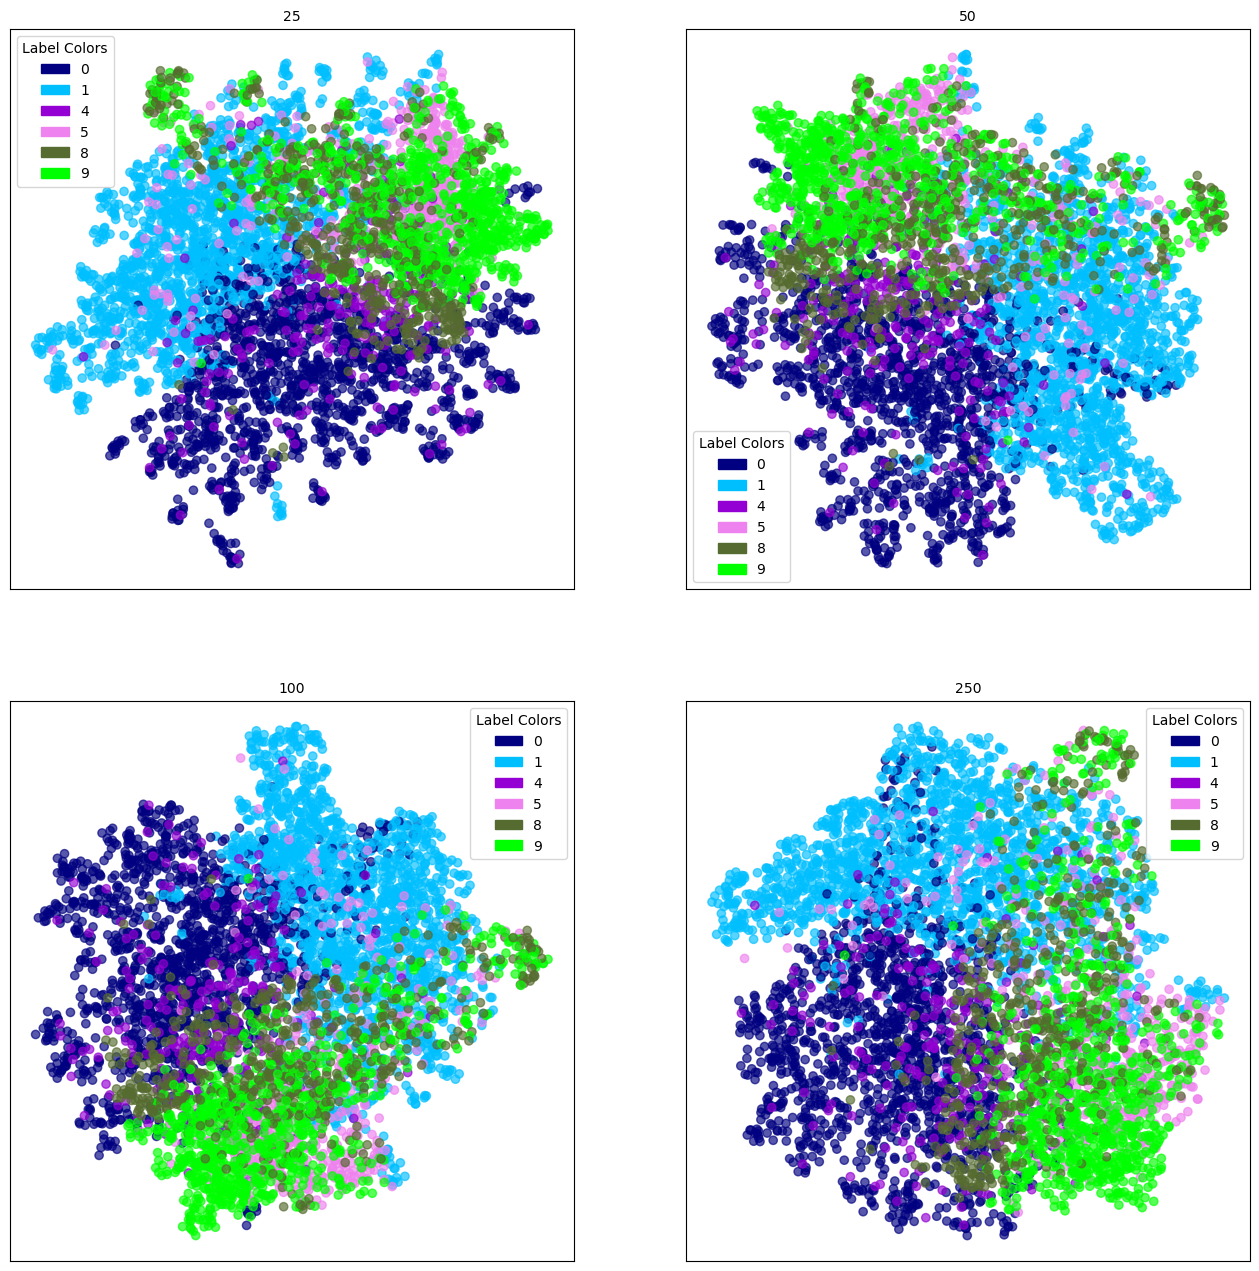

In [163]:
number_neighbors = [25,50,100,250]
ds_dict = {
    'training': 'msld-v1',
    'features': ['msld-v1', 'msid-binary', 'mpox-ds-2022-binary']
}
nrows, ncols = 2,2
fig,axs = plt.subplots(nrows,ncols, figsize=(8*ncols,8*nrows))
axs = axs.flatten()
for ax, n_neighbors in zip(axs, number_neighbors):
    print(f"UMAP with {n_neighbors} neighbors")
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric='euclidean', min_dist=0.9, n_components=2)
    reducer.fit(features)
    embedding = reducer.transform(features)

    plot_features(embedding, labels, predictions, ds_dict, preds_to_show='all', title=n_neighbors, ax=ax)
plt.show()  

UMAP with euclidean
UMAP with cosine


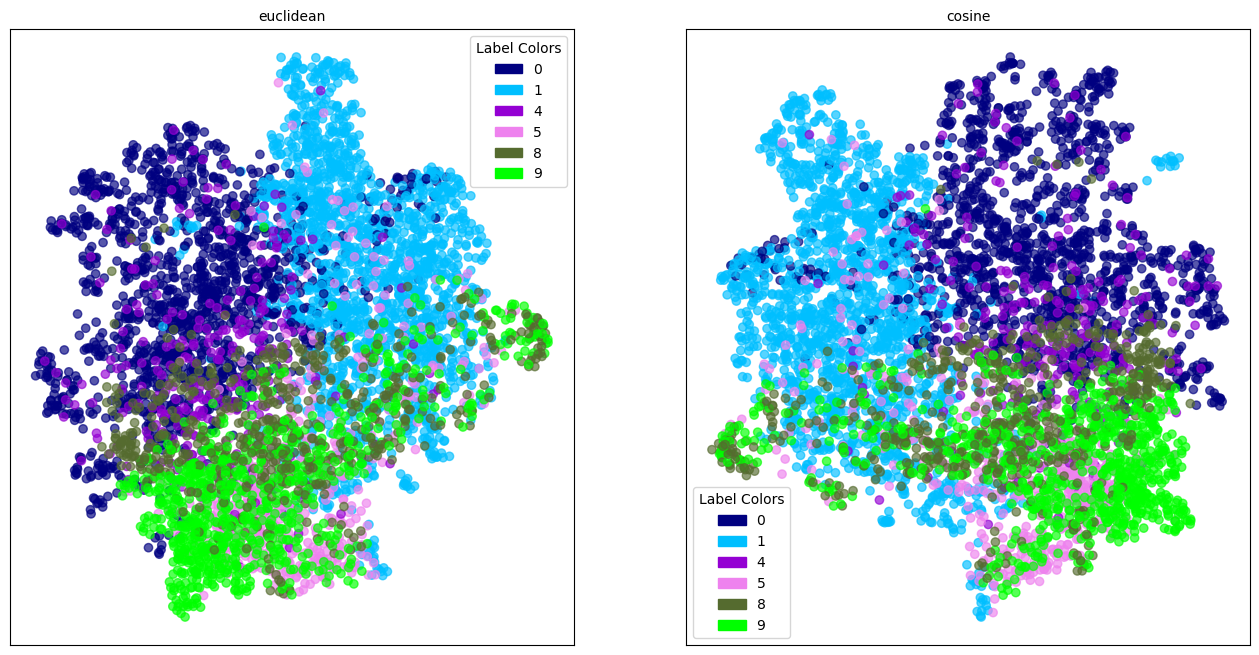

In [166]:
metrics = ['euclidean', 'cosine']
ds_dict = {
    'training': 'msld-v1',
    'features': ['msld-v1', 'msid-binary', 'mpox-ds-2022:mpox']
}
nrows, ncols = 1,2
fig,axs = plt.subplots(nrows,ncols, figsize=(8*ncols,8*nrows))
axs = axs.flatten()
for ax, metric in zip(axs, metrics):
    print(f"UMAP with {metric}")
    reducer = umap.UMAP(n_neighbors=100, metric=metric, min_dist=0.75, n_components=2)
    reducer.fit(features)
    embedding = reducer.transform(features)

    plot_features(embedding, labels, predictions, ds_dict, preds_to_show='all', title=metric, ax=ax)
plt.show()  

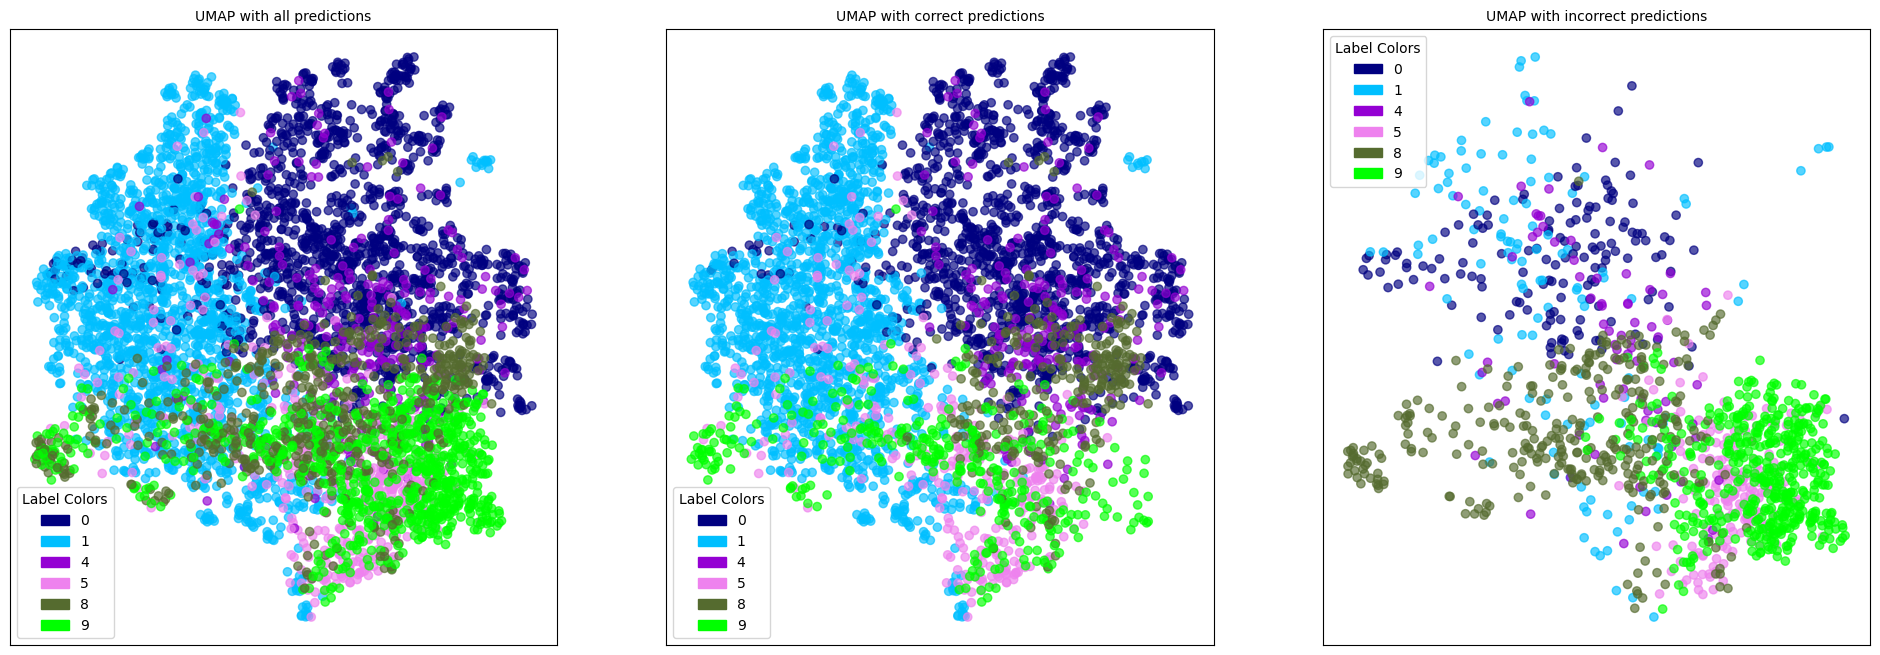

In [170]:
filters = ['all', 'correct', 'incorrect']
ds_dict = {
    'training': 'msld-v1',
    'features': ['msld-v1', 'msid-binary', 'mpox-ds-2022:mpox']
}
nrows, ncols = 1,3
fig,axs = plt.subplots(nrows,ncols, figsize=(8*ncols,8*nrows))
axs = axs.flatten()
reducer = umap.UMAP(n_neighbors=100, metric='cosine', min_dist=0.75, n_components=2)
reducer.fit(features)
embedding = reducer.transform(features)
for ax, f in zip(axs, filters):
    plot_features(embedding, labels, predictions, ds_dict, preds_to_show=f, title=f"UMAP with {f} predictions", ax=ax)
plt.show()  

In [ ]:
nb_models = len(saved_model_files)
datasets = ['msld-v1', 'msid-binary', 'mpox-ds-2022:mpox']
dataset_paths=[DATASETS[k]['path'] for k in datasets]
ds_dict = {
    'training': 'msld-v1',
    'features': datasets
}

ncols = 2
nrows = (nb_models + ncols - 1) // ncols  # Calculate number of rows needed
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows), sharex=False, sharey=False)
axs = axs.flatten() if nb_models > 1 else [axs]
for ax,model_file in zip(axs,saved_model_files):
    features, labels = create_image_features(
        saved_model_file=model_file,
        selected_arch=selected_arch,
        dataset_paths=dataset_paths,
    )
    reducer = umap.UMAP()
    reducer.fit(features)
    embedding = reducer.transform(features)
    plot_features(embedding, labels, ds_dict, ax=ax)

In [ ]:
from sklearn.cluster import dbscan, k_means, DBSCAN, KMeans

In [ ]:
dbs = DBSCAN(eps=8)
dbs.fit(features);
np.unique(dbs.labels_)

In [ ]:
np.unique(dbs.labels_)

In [ ]:
loc = [
    'lightcoral',
    'firebrick',
    'sienna',
    'chocolate',
    'gold',
    'yellow',
    'darkolivegreen',
    'palegreen',
    'turquoise',
    'darkcyan',
    'slateblue',
    'violet',
]

In [ ]:
dbscan?

In [ ]:
DBSCAN?

## Using densenet169 fine-tuned with `msld-v1`

In [ ]:
selected_arch = densenet169
dataset = 'msld-v1'

saved_model_files = model_weight_files(arch=selected_arch, dataset=dataset)
saved_model_files

In [ ]:
datasets = ['msld-v1', 'msid-binary', 'mpox-ds-2022:mpox']
dataset_paths=[DATASETS[k]['path'] for k in datasets]

features, labels = create_image_features(
    saved_model_file=saved_model_files[0],
    selected_arch=selected_arch,
    dataset_paths=dataset_paths
)
features.shape, labels.shape, np.unique(labels)

In [ ]:
reducer = umap.UMAP()
reducer.fit(features)
embedding = reducer.transform(features)

ds_dict = {
    'training': 'msld-v1',
    'features': ['msld-v1', 'msid-binary', 'mpox-ds-2022:mpox']
}
plot_features(embedding, labels, ds_dict)

In [ ]:
nb_models = len(saved_model_files)
datasets = ['msld-v1', 'msid-binary', 'mpox-ds-2022:mpox']
dataset_paths=[DATASETS[k]['path'] for k in datasets]
ds_dict = {
    'training': 'msld-v1',
    'features': datasets
}

ncols = 2
nrows = (nb_models + ncols - 1) // ncols  # Calculate number of rows needed
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows), sharex=False, sharey=False)
axs = axs.flatten() if nb_models > 1 else [axs]
for ax,model_file in zip(axs,saved_model_files):
    features, labels = create_image_features(
        saved_model_file=model_file,
        selected_arch=selected_arch,
        dataset_paths=dataset_paths,
    )
    reducer = umap.UMAP()
    reducer.fit(features)
    embedding = reducer.transform(features)
    plot_features(embedding, labels, ds_dict, ax=ax)

# Others

In [11]:
import math

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

In [12]:
# colors = list(mcolors.CSS4_COLORS)
# names = sorted(colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))

# for c in names:
#     print(f"    '{c}',")

In [47]:
loc = [
    # 'black',
    # 'dimgray',
    # 'dimgrey',
    # 'gray',
    # 'grey',
    # 'darkgray',
    # 'darkgrey',
    # 'silver',
    # 'lightgray',
    # 'lightgrey',
    # 'gainsboro',
    # 'whitesmoke',
    # 'white',
    # 'snow',
    # 'rosybrown',
    'lightcoral',
    # 'indianred',
    # 'brown',
    'firebrick',
    # 'maroon',
    # 'darkred',
    # 'red',
    # 'mistyrose',
    # 'salmon',
    # 'tomato',
    # 'darksalmon',
    # 'coral',
    # 'orangered',
    # 'lightsalmon',
    'sienna',
    # 'seashell',
    # 'chocolate',
    # 'saddlebrown',
    # 'sandybrown',
    # 'peachpuff',
    # 'peru',
    # 'linen',
    # 'bisque',
    # 'darkorange',
    # 'burlywood',
    # 'antiquewhite',
    'tan',
    # 'navajowhite',
    # 'blanchedalmond',
    # 'papayawhip',
    # 'moccasin',
    # 'orange',
    # 'wheat',
    # 'oldlace',
    # 'floralwhite',
    # 'darkgoldenrod',
    # 'goldenrod',
    # 'cornsilk',
    'gold',
    # 'lemonchiffon',
    # 'khaki',
    # 'palegoldenrod',
    # 'darkkhaki',
    # 'ivory',
    # 'beige',
    # 'lightyellow',
    # 'lightgoldenrodyellow',
    # 'olive',
    'yellow',
    # 'olivedrab',
    # 'yellowgreen',
    'darkolivegreen',
    # 'greenyellow',
    # 'chartreuse',
    # 'lawngreen',
    # 'honeydew',
    # 'darkseagreen',
    # 'palegreen',
    # 'lightgreen',
    # 'forestgreen',
    'limegreen',
    # 'darkgreen',
    # 'green',
    # 'lime',
    # 'seagreen',
    # 'mediumseagreen',
    # 'springgreen',
    # 'mintcream',
    # 'mediumspringgreen',
    # 'mediumaquamarine',
    # 'aquamarine',
    # 'turquoise',
    # 'lightseagreen',
    # 'mediumturquoise',
    # 'azure',
    # 'lightcyan',
    # 'paleturquoise',
    # 'darkslategray',
    # 'darkslategrey',
    # 'teal',
    # 'darkcyan',
    # 'aqua',
    # 'cyan',
    # 'darkturquoise',
    # 'cadetblue',
    # 'powderblue',
    # 'lightblue',
    'deepskyblue',
    # 'skyblue',
    # 'lightskyblue',
    # 'steelblue',
    # 'aliceblue',
    # 'dodgerblue',
    # 'lightslategray',
    # 'lightslategrey',
    # 'slategray',
    # 'slategrey',
    # 'lightsteelblue',
    # 'cornflowerblue',
    # 'royalblue',
    # 'ghostwhite',
    # 'lavender',
    # 'midnightblue',
    'navy',
    # 'darkblue',
    # 'mediumblue',
    # 'blue',
    # 'slateblue',
    # 'darkslateblue',
    # 'mediumslateblue',
    # 'mediumpurple',
    # 'rebeccapurple',
    # 'blueviolet',
    # 'indigo',
    # 'darkorchid',
    'darkviolet',
    # 'mediumorchid',
    # 'thistle',
    # 'plum',
    'violet',
    # 'purple',
    # 'darkmagenta',
    # 'fuchsia',
    # 'magenta',
    # 'orchid',
    # 'mediumvioletred',
    # 'deeppink',
    # 'hotpink',
    # 'lavenderblush',
    # 'palevioletred',
    # 'crimson',
    # 'pink',
    # 'lightpink',
]

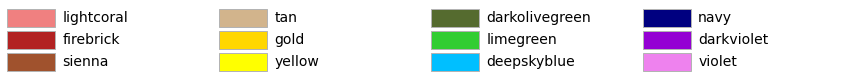

    'lightcoral',
    'firebrick',
    'sienna',
    'tan',
    'gold',
    'yellow',
    'darkolivegreen',
    'limegreen',
    'deepskyblue',
    'navy',
    'darkviolet',
    'violet',


In [48]:
colors = {k:v for k,v in mcolors.CSS4_COLORS.items() if k in loc}
plot_colortable(colors)
# plot_colortable(mcolors.CSS4_COLORS)
plt.show()
for c in loc:
    print(f"    '{c}',")

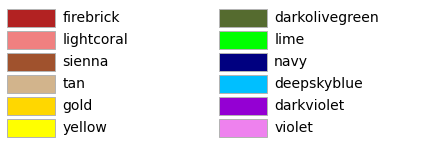

In [49]:
sorted_loc = [
    'firebrick',
    'lightcoral',
    'sienna',
    'tan',
    'gold',
    'yellow',
    'darkolivegreen',
    'lime',
    'navy',
    'deepskyblue',
    'darkviolet',
    'violet',
]
css_colors = mcolors.CSS4_COLORS
colors = {k:css_colors[k] for  k in sorted_loc}
plot_colortable(colors, ncols=2, sort_colors=False)
plt.show()


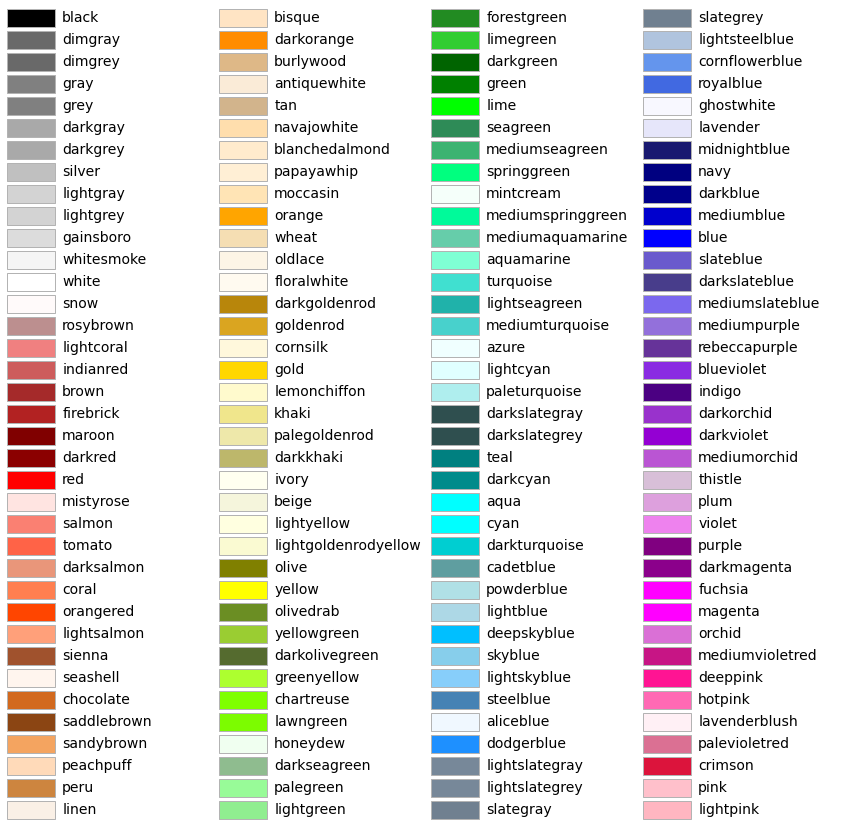

In [50]:
plot_colortable(mcolors.CSS4_COLORS)
plt.show()